In [1]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from time import sleep
from enum import Enum
import copy
from scipy.signal import correlate2d
import random
import time
import datetime
import json
import os

# Here's how animate works
# https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code
# https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.clear_output


In [2]:
u = 0.09
kernel = np.array(
    [
        [1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3],
        [1 / 3, 1 / 2, 1 / 2, 1 / 2, 1 / 2, 1 / 2, 1 / 3],
        [1 / 3, 1 / 2, 1, 1, 1, 1 / 2, 1 / 3],
        [1 / 3, 1 / 2, 1, 0, 1, 1 / 2, 1 / 3],
        [1 / 3, 1 / 2, 1, 1, 1, 1 / 2, 1 / 3],
        [1 / 3, 1 / 2, 1 / 2, 1 / 2, 1 / 2, 1 / 2, 1 / 3],
        [1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3, 1 / 3],
    ]
)
total_interactions = np.sum(kernel)
kernel[2][2] = -u * total_interactions


class Strategy(Enum):
    c = 0
    d = 1
    s = 2
    t = 3


colors = {
    Strategy.c: [1.0, 0, 0],
    Strategy.d: [0, 0, 1.0],
    (Strategy.s, 0): [0.1, 0, 0.9],
    (Strategy.s, 1): [0.9, 0, 0.1],
    Strategy.t: [0, 1.0, 0],
}


def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

	d: dictionary
	options: keyword args to add to d
	"""
    for key, val in options.items():
        d.setdefault(key, val)

    return d

In [3]:
class Agent:
    def __init__(self, strategy=Strategy.d, silent_coop=False):

        self.silent_coop_chance = 1e-4
        self.inherent_fitness = 0
        self.strategy = strategy
        self.coop_valid = silent_coop
        self.memory = 1

        if silent_coop:
            if np.random.random() < self.silent_coop_chance:
                self.silent_coop = True
                self.time_to_cooperate = int(np.random.exponential(200))
                self.strategy = Strategy.s
                # print(self.time_to_cooperate)
            else:
                self.time_to_cooperate = None
                self.silent_coop = False
        else:
            self.time_to_cooperate = None
            self.silent_coop = False

    def __tostr__(self):
        return str(self.strategy)

    def cooperate_p(self, t):
        if self.strategy == Strategy.c:
            return True
        elif self.strategy == Strategy.d:
            return False
        elif self.strategy == Strategy.s:
            return self.time_to_cooperate < t
        elif self.strategy == Strategy.t:
            return self.memory > 0.4

    def mutate(self, mutate_rate, curr_step):
        """
		Placeholder function; fort the first type of world we do not have a mutate function,
		so we will come back to implmenet later
		"""
        num = np.random.rand()
        if num < mutate_rate:
            if self.coop_valid:
                self.strategy = Strategy.s
                self.time_to_cooperate = int(np.random.exponential(200)) + curr_step
                # print("that worked?!", self.time_to_cooperate)
            else:
                if self.strategy == Strategy.d:
                    self.strategy = Strategy.c

    def add_memory(self, frac_coop):
        self.memory = frac_coop


In [4]:
class BasicWorld:
    def __init__(
        self,
        n=50,
        m=None,
        do_mutation=False,
        do_silent=False,
        bounds=None,
        mutate_rate=0,
        silent_coop=False,
    ):
        """
		bounds is a tuple of (x_start, y_start, x_end, y_end) for a block of
		cooperators among the sea of defectors.
		"""

        def agent_at_pos(x, y):
            if bounds is None:
                return Agent(silent_coop=silent_coop)
            else:
                if (bounds[0] < x < bounds[2]) and (bounds[1] < y < bounds[3]):
                    # return Agent(strategy=Strategy.c, silent_coop=silent_coop)
                    return Agent(strategy=Strategy.t, silent_coop=silent_coop)
                else:
                    return Agent(silent_coop=silent_coop)

        self.curr_step = 0

        self.mutate_rate = mutate_rate

        self.n = n
        if m is None:
            m = self.n
        self.m = m

        self.array = [
            [agent_at_pos(x, y) for x in range(self.m)] for y in range(self.n)
        ]

        self.inherent_fitness_increment_prob = 0.001
        self.inherent_fitness_increment_amt = 0.1
        self.normalization_constant = 24 * (1 + u)

    def make_pd_results(self):
        """
		Makes an n x m array, where elements are the fitnesses that agents get
		from playing the PD, both from defecting and from having others
		cooperate with them.  Boundary conditions are periodic, i.e. agents at
		the far left play against agents at the far right.
		"""
        coop_array = np.array(
            [
                [1 if agent.cooperate_p(self.curr_step) else 0 for agent in row]
                for row in self.array
            ]
        )

        pd_results = correlate2d(coop_array, kernel, mode="same", boundary="wrap")

        frac_coop = (pd_results - (coop_array * kernel[2][2])) / total_interactions
        for i, row in enumerate(self.array):
            for j, agent in enumerate(row):
                agent.add_memory(frac_coop[i, j])

        return pd_results

    def make_fitness_array(self):
        """
		Makes an n x m array, where each element is that agent's fitness,
		derived from its and others' behaviors and their inherent fitnesses.
		"""
        inherent_fitnesses = np.array(
            [[agent.inherent_fitness for agent in row] for row in self.array]
        )
        pd_results = self.make_pd_results()
        return pd_results + inherent_fitnesses

    def step(self):
        """
		Runs a step of the simulation.
		* Calculate fitness of each agent
		* Figure out who conquers whom, and let them conquer
		* Randomly increment inherent fitnesses
		"""
        # make fitness array
        arr = self.make_fitness_array()

        # determine who conquers whom in the local area
        # ORIGINAL IMPLEMENTATION:
        # for "conquering", we look at every cell in a random order
        # after picking a cell we then look at ONE OF the four "direct" neighbors (cardinal directions)
        # we compare fitnesses. If our current cell is higher, do nothing.
        # If our current cell has lower fitness we can be replaced with the other cell

        conquering_pairs = []  # Pairs of (conqueror, to_be_conquered)
        locs = [(x, y) for x in range(self.m) for y in range(self.m)]
        np.random.shuffle(locs)

        def nonce_func_1():
            for x, y in locs:
                cells_to_compare = [
                    ((x - 1) % self.m, y),
                    ((x + 1) % self.m, y),
                    (x, (y - 1) % self.n),
                    (x, (y + 1) % self.n),
                ]
                look_loc = cells_to_compare[
                    random.getrandbits(2)
                ]  # Faster than randint

                invader_val = arr[look_loc[0]][look_loc[1]]
                curr_val = arr[x][y]

                if invader_val > curr_val:
                    if (
                        invader_val - curr_val
                    ) / self.normalization_constant > np.random.rand(1, 1):
                        conquering_pairs.append((look_loc, (x, y)))

        nonce_func_1()

        # have conquering happen [update matrices/agents] -> mutation at odds mut_chance or whatever
        for x in conquering_pairs:
            conqueror_loc = x[0]
            conquered_loc = x[1]
            self.array[conquered_loc[0]][conquered_loc[1]] = copy.deepcopy(
                self.array[conqueror_loc[0]][conqueror_loc[1]]
            )
            self.array[conquered_loc[0]][conquered_loc[1]].mutate(
                mutate_rate=self.mutate_rate, curr_step=self.curr_step
            )

        # Increment random inherent_fitness vars
        for agent in [agent for row in self.array for agent in row]:
            if np.random.random() < self.inherent_fitness_increment_prob:
                agent.inherent_fitness += self.inherent_fitness_increment_amt

        self.curr_step += 1

        return

    def draw_array(self, array, **options):
        """Draws the cells."""
        n, m, _ = array.shape
        options = underride(
            options,
            # cmap="bwr",
            alpha=1,
            vmin=0,
            vmax=1,
            interpolation="none",
            origin="upper",
            extent=[0, m, 0, n],
        )

        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])
        plt.title(f"World state on turn {self.curr_step}")
        red_patch = mpatches.Patch(color=colors[Strategy.c], label="Cooperator")
        blue_patch = mpatches.Patch(color=colors[Strategy.d], label="Defector")
        green_patch = mpatches.Patch(color=colors[Strategy.t], label="Tit-For-Tat")
        plt.legend(
            handles=[red_patch, blue_patch, green_patch],
            loc="center left",
            bbox_to_anchor=(1, 0.5),
        )

        return plt.imshow(array, **options)

    def draw(self, interval=None, step=None):
        """
		Gets the current np array state then draws the array
		"""

        def agent_to_color(agent):
            if agent.strategy == Strategy.s:
                return colors[(Strategy.s, agent.cooperate_p(self.curr_step))]
            else:
                return colors[agent.strategy]

        arr = np.asarray(
            [[agent_to_color(agent) for agent in row] for row in self.array]
        )

        self.draw_array(arr)

    def animate(self, frames, interval=None, skip=0, step=None):
        """Animate the automaton.

		frames: number of frames to draw
		interval: time between frames in seconds
		iters: number of steps between frames
		"""
        if step is None:
            step = self.step

        if interval is None:
            interval = 0.01

        plt.figure()
        try:
            for i in range(frames - 1):
                self.draw()
                # plt.show(block=False)
                plt.pause(interval)
                for _ in range(skip + 1):
                    step()
                plt.clf()
                # clear_output(wait=True)
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass

    def get_stats(self):
        """
		Get some summary statistics that might be useful for graphing.  Stats
		are returned as a dict.
		Stats are:
		* "time" : current timestep
		* "num_c", "num_d", "num_s": Number of agents in each state
		TODO: Should we refactor this so it returns lists or something?
		"""

        stats = {"time": self.curr_step}

        def count_strat(s):
            return np.sum(
                [
                    (1 if agent.strategy == s else 0)
                    for row in self.array
                    for agent in row
                ]
            )

        stats["num_c"] = count_strat(Strategy.c)
        stats["num_d"] = count_strat(Strategy.d)
        stats["num_s"] = count_strat(Strategy.s)
        stats["num_t"] = count_strat(Strategy.t)

        return stats

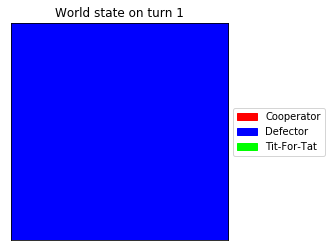

0.0


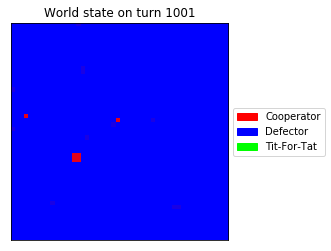

10.0


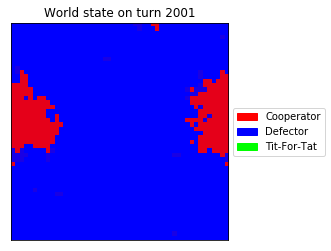

20.0


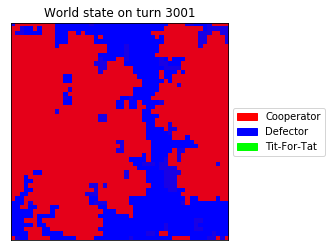

30.0


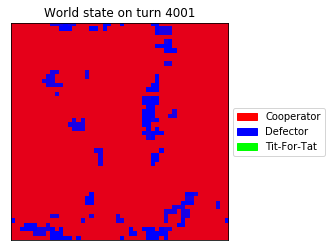

40.0


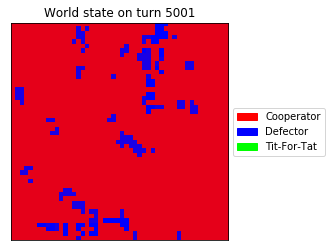

50.0


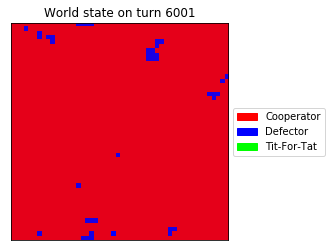

60.0


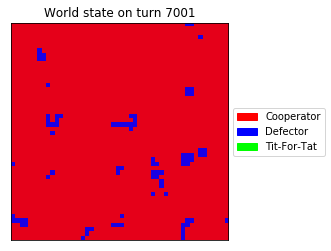

70.0


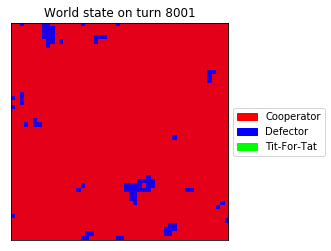

80.0


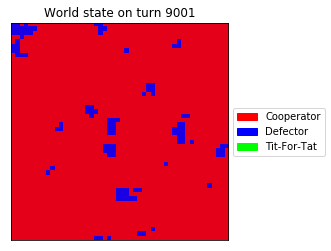

90.0


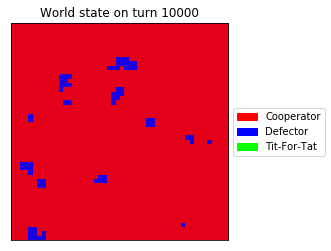

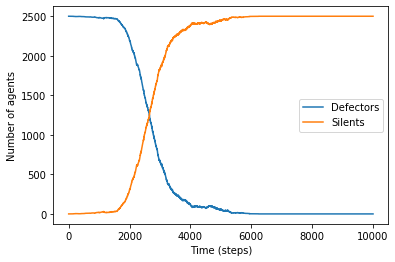

In [6]:
mutate_rate = 1e-4
num = 1
# Experiment 1:
# mutate_rate = 0
# num = 10000
# world = BasicWorld(n=50, bounds=[17,17,22,22], mutate_rate=mutate_rate, silent_coop=False)

# Experiment 2:
# mutate_rate = 1e-2
# num = 10000
# world = BasicWorld(n=50, mutate_rate=mutate_rate, silent_coop=False)

# Experiment 3:
mutate_rate = 1e-2
num = 10000
world = BasicWorld(n=50, mutate_rate=mutate_rate, silent_coop=True)

# Experiment 4:
# mutate_rate = 1e-4
# num = 100000

# Experiment 5:
# mutate_rate = 1e-2
# num = 10000
#world = BasicWorld(n=50, do_mutation=False, bounds=(17, 17, 23, 23), silent_coop=False)


stats = {"time": [], "num_c": [], "num_d": [], "num_s": [], "num_t": []}

for x in range(num):
    world.step()
    for key, value in world.get_stats().items():
        if type(value) == np.int64:
            stats[key].append(int(value))
        else:
            stats[key].append(value)

    if x % 1000 == 0:
        # if False:
        world.animate(1)
        print(x / num * 100)

world.animate(1)

if max(stats["num_c"]) > 0:
    plt.plot(stats["time"], stats["num_c"], label="Cooperators")
if max(stats["num_d"]) > 0:
    plt.plot(stats["time"], stats["num_d"], label="Defectors")
if max(stats["num_s"]) > 0:
    plt.plot(stats["time"], stats["num_s"], label="Silents")
if max(stats["num_t"]) > 0:
    plt.plot(stats["time"], stats["num_t"], label="Tit-For-Tats")

plt.xlabel("Time (steps)")
plt.ylabel("Number of agents")
plt.legend()
plt.show()




In [7]:
# Dump json if local
jsons = "jsons/"
file = f'{num}_timesteps_on_{datetime.datetime.now().strftime("%B %d %Y at %I:%M:%S%p")}.json'
if not os.path.isdir(jsons):
    os.mkdir(jsons)
json.dump(stats, open(jsons + file, "w"), sort_keys=True, indent=4)